# imports

In [1]:
from __future__ import division
import os # to set working directory
import csv # to read/write csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display
from sklearn.preprocessing import Imputer # for imputing missing values
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # for heatmaps

# parameters

In [2]:
prm_dir='C:/Users/home/Dropbox/IoT_Research/hackathon_2018_IoT_device_type_identification'

## set working directory

In [4]:
os.chdir(prm_dir)
# os.listdir(prm_dir)

## set random seed (for reproducibility)

In [5]:
np.random.seed(23)

# read the data sets

In [18]:
# training set
df_trn = pd.read_csv('hackathon_IoT_training_set_based_on_01mar2017.csv', low_memory=False, na_values='?')

# validation set - anonymized
df_vld = pd.read_csv('hackathon_IoT_validation_set_based_on_01mar2017_ANONYMIZED.csv', low_memory=False, na_values='?')

# validation set - actual types (true labels)
y_vld_ind_and_actual = pd.read_csv('hackathon_IoT_validation_set_based_on_01mar2017_COMPLETE.csv', low_memory=False, na_values='?'
                                  ,usecols = ['session_ind', 'device_category'])

## explore the training data

In [7]:
print(df_trn.shape) # dimensions (rows, columns)
display(df_trn.head()) # overview of first (last) rows
display(df_trn.describe().T) # basic stats per variable

(399543, 298)


,ack,ack_A,ack_B,bytes,bytes_A,bytes_A_B_ratio,bytes_B,ds_field_A,ds_field_B,duration,...,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved,device_category
0,9,5,5,1213,743,0.713924,668,0,0,1.5756,...,0,0,0,1,0,0,0,0,0,security_camera
1,9,5,5,1213,743,1.806874,668,0,0,0.6890,...,0,0,0,1,0,0,0,0,0,security_camera
2,9,5,5,1213,743,0.103124,668,0,0,0.9852,...,0,0,0,1,0,0,0,0,0,security_camera
3,9,5,5,1213,743,1.806874,668,0,0,1.5756,...,0,0,0,1,0,0,0,0,0,security_camera
4,9,5,5,1213,743,1.806874,668,0,0,1.5756,...,0,0,0,1,0,0,0,0,0,security_camera


,count,mean,std,min,25%,50%,75%,max
ack,399543.0,102.964712,6.572751e+03,0.0,0.0000,2.000000,9.000000,6.528710e+05
ack_A,399543.0,58.426825,4.062538e+03,0.0,0.0000,1.000000,5.000000,4.045370e+05
ack_B,399543.0,44.697232,2.526283e+03,0.0,0.0000,1.000000,5.000000,2.545570e+05
bytes,399543.0,65694.959359,4.398723e+06,60.0,240.0000,240.000000,1213.000000,4.282699e+08
bytes_A,399543.0,15072.439039,6.572074e+05,0.0,0.0000,60.000000,743.000000,2.108971e+08
bytes_A_B_ratio,399543.0,0.632087,1.951254e+00,0.0,0.0000,0.101351,0.719532,9.234373e+01
bytes_B,399543.0,50652.271225,4.186674e+06,0.0,240.0000,240.000000,668.000000,4.127341e+08
ds_field_A,399543.0,0.000000,0.000000e+00,0.0,0.0000,0.000000,0.000000,0.000000e+00
ds_field_B,399543.0,32.274333,3.189747e+01,0.0,0.0000,64.000000,64.000000,1.280000e+02
duration,399543.0,52.707011,1.420455e+03,0.0,1.4739,1.499200,1.575600,4.342019e+05


## data types

In [8]:
df_trn.dtypes.value_counts()

float64    201
int64       96
object       1
dtype: int64

## data exploration

the value counts of the target are:
lights             100000
socket             100000
TV                  59069
baby_monitor        51377
motion_sensor       50712
thermostat          18814
security_camera     14190
watch                4187
water_sensor         1026
smoke_detector        168
Name: device_category, dtype: int64
Axes(0.125,0.125;0.775x0.755)


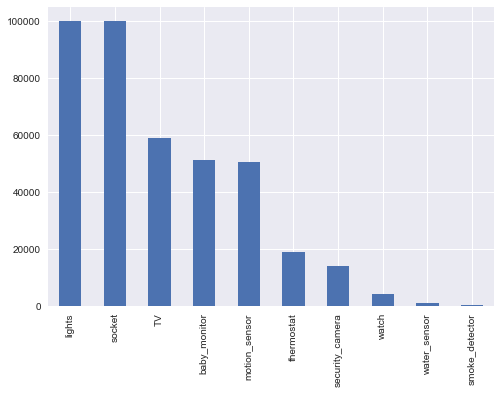

In [9]:
print('the value counts of the target are:')
print(df_trn.iloc[:,-1].value_counts())
print(df_trn.iloc[:,-1].value_counts().plot(kind = 'bar'))

## prepare data for modeling

In [10]:
y_trn = df_trn.iloc[:,(df_trn.shape[1]-1)].copy() # last column
X_trn = df_trn.iloc[:,0:(df_trn.shape[1]-1)].copy() # all but the last column

In [11]:
X_trn.head()

,ack,ack_A,ack_B,bytes,bytes_A,bytes_A_B_ratio,bytes_B,ds_field_A,ds_field_B,duration,...,suffix_is_cloudfront.net,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved
0,9,5,5,1213,743,0.713924,668,0,0,1.5756,...,0,0,0,0,1,0,0,0,0,0
1,9,5,5,1213,743,1.806874,668,0,0,0.6890,...,0,0,0,0,1,0,0,0,0,0
2,9,5,5,1213,743,0.103124,668,0,0,0.9852,...,0,0,0,0,1,0,0,0,0,0
3,9,5,5,1213,743,1.806874,668,0,0,1.5756,...,0,0,0,0,1,0,0,0,0,0
4,9,5,5,1213,743,1.806874,668,0,0,1.5756,...,0,0,0,0,1,0,0,0,0,0


## handle missing values

In [12]:
# summary of missing values
X_trn.isnull().sum().value_counts()

0      165
185     84
10      48
dtype: int64

In [13]:
# elaborate on the number of missing values per feature
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(df_trn.isnull().sum())

ack                                     0
ack_A                                   0
ack_B                                   0
bytes                                   0
bytes_A                                 0
bytes_A_B_ratio                         0
bytes_B                                 0
ds_field_A                              0
ds_field_B                              0
duration                                0
http_GET                              185
http_POST                             185
http_bytes_avg                        185
http_bytes_entropy                    185
http_bytes_firstQ                     185
http_bytes_max                        185
http_bytes_median                     185
http_bytes_min                        185
http_bytes_stdev                      185
http_bytes_sum                        185
http_bytes_thirdQ                     185
http_bytes_var                        185
http_cookie_count                     185
http_cookie_values_avg            

In [14]:
# fill values that are missing because the respective sessions are
# 1. not HTTP
# 2. not SSL
X_trn.fillna(value=0, inplace=True)

## train a classifier

In [15]:
# train a random forest
RFmodel = RandomForestClassifier(n_estimators=50)
RFmodel.fit(X_trn,y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
# column names
X_names = list(X_trn) 

# feature importance as per the random forest
featimp = pd.Series(RFmodel.feature_importances_, index=X_names).sort_values(ascending=False)
print(featimp)

ttl_min                              0.029559
packet_inter_arrivel_A_firstQ        0.028963
B_port_is_8080                       0.028595
packet_inter_arrivel_sum             0.026457
packet_inter_arrivel_A_avg           0.024948
ttl_B_min                            0.024795
packet_inter_arrivel_A_sum           0.024672
packet_inter_arrivel_A_max           0.022845
packet_inter_arrivel_max             0.022617
packet_inter_arrivel_A_stdev         0.021933
bytes_A                              0.021886
packet_inter_arrivel_stdev           0.021508
packet_inter_arrivel_A_var           0.020923
packet_inter_arrivel_A_thirdQ        0.020702
packet_inter_arrivel_thirdQ          0.020606
packet_inter_arrivel_avg             0.018840
ttl_A_avg                            0.018220
bytes_A_B_ratio                      0.017682
packet_inter_arrivel_var             0.017319
ttl_median                           0.017262
ttl_A_min                            0.017061
ttl_avg                           

In [17]:
featimp[featimp>0.02].keys

<bound method Series.keys of ttl_min                          0.029559
packet_inter_arrivel_A_firstQ    0.028963
B_port_is_8080                   0.028595
packet_inter_arrivel_sum         0.026457
packet_inter_arrivel_A_avg       0.024948
ttl_B_min                        0.024795
packet_inter_arrivel_A_sum       0.024672
packet_inter_arrivel_A_max       0.022845
packet_inter_arrivel_max         0.022617
packet_inter_arrivel_A_stdev     0.021933
bytes_A                          0.021886
packet_inter_arrivel_stdev       0.021508
packet_inter_arrivel_A_var       0.020923
packet_inter_arrivel_A_thirdQ    0.020702
packet_inter_arrivel_thirdQ      0.020606
dtype: float64>

# validation

In [23]:
X_vld = df_vld.iloc[:,0:(df_vld.shape[1]-1)].copy() # all but the last column
y_vld = y_vld_ind_and_actual['device_category']


examine missing values in the validation set

In [20]:
X_vld.isnull().sum().value_counts()

0    297
dtype: int64

In [21]:
# fill missing values
# 1. not HTTP
# 2. not SSL
# X_vld.fillna(value=0, inplace=True)

## apply model on the validation model for prediction

In [22]:
# predict class
y_vld_pred = RFmodel.predict(X_vld)
print(y_vld_pred)

['motion_sensor' 'TV' 'baby_monitor' 'socket' 'socket' 'smoke_detector'
 'socket' 'TV' 'smoke_detector' 'motion_sensor' 'security_camera' 'lights'
 'TV' 'socket' 'smoke_detector' 'watch' 'socket' 'watch' 'watch'
 'security_camera' 'baby_monitor' 'motion_sensor' 'socket' 'thermostat'
 'watch' 'smoke_detector' 'socket' 'watch' 'TV' 'baby_monitor'
 'motion_sensor' 'watch' 'security_camera' 'smoke_detector' 'baby_monitor'
 'smoke_detector' 'security_camera' 'lights' 'TV' 'smoke_detector' 'socket'
 'thermostat' 'watch' 'socket' 'security_camera' 'baby_monitor'
 'thermostat' 'TV' 'baby_monitor' 'baby_monitor' 'motion_sensor'
 'security_camera' 'motion_sensor' 'smoke_detector' 'security_camera'
 'thermostat' 'smoke_detector' 'smoke_detector' 'socket' 'smoke_detector'
 'watch' 'watch' 'watch' 'TV' 'watch' 'thermostat' 'watch'
 'security_camera' 'watch' 'socket' 'TV' 'smoke_detector' 'TV'
 'smoke_detector' 'socket' 'security_camera' 'TV' 'TV' 'security_camera'
 'smoke_detector' 'TV' 'smoke_dete

## examine classification accuracy

In [24]:
print(classification_report(y_vld, y_vld_pred))
# precision = tp / (tp + fp) = tp / "p" = the ability of the classifier not to label as positive a sample that is negative
# recall = tp / (tp + fn) = tp / p = the ability of the classifier to find all the positive samples
# f1-score = weighted harmonic mean of the precision and recall
# support = number of occurrences of each class in y_true

                 precision    recall  f1-score   support

             TV       0.50      1.00      0.66       100
   baby_monitor       1.00      1.00      1.00       100
         lights       1.00      0.19      0.32       100
  motion_sensor       0.96      0.99      0.98       100
security_camera       1.00      0.96      0.98       100
 smoke_detector       1.00      1.00      1.00       100
         socket       0.55      0.97      0.70       100
     thermostat       1.00      1.00      1.00       100
        unknown       0.00      0.00      0.00       100
          watch       1.00      1.00      1.00       100
   water_sensor       0.00      0.00      0.00         0

    avg / total       0.80      0.81      0.76      1000



C:\Users\home\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\home\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [25]:
# confusion_matrix
pd.crosstab(y_vld, y_vld_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,TV,baby_monitor,lights,motion_sensor,security_camera,smoke_detector,socket,thermostat,watch,water_sensor,All
True,,,,,,,,,,,
TV,100,0,0,0,0,0,0,0,0,0,100
baby_monitor,0,100,0,0,0,0,0,0,0,0,100
lights,0,0,19,0,0,0,80,0,0,1,100
motion_sensor,1,0,0,99,0,0,0,0,0,0,100
security_camera,0,0,0,4,96,0,0,0,0,0,100
smoke_detector,0,0,0,0,0,100,0,0,0,0,100
socket,0,0,0,0,0,0,97,0,0,3,100
thermostat,0,0,0,0,0,0,0,100,0,0,100
unknown,100,0,0,0,0,0,0,0,0,0,100


## calculate the classification accuracy on the validation set

In [31]:
classification_accuracy = sum(y_vld==y_vld_pred)/len(y_vld)
classification_accuracy

0.81100000000000005